In [ ]:
print("Installation of required package")
!pip install torch_geometric

Installation of required package
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.6 MB/s eta 0:00:00


---


In [ ]:
!pip3 install  dgl -f https://data.dgl.ai/wheels/torch-2.3/repo.html
!pip3 install numpy
!pip3 install torch
!pip3 install networkx
!pip3 install matplotlib
!pip install torch_geometric
!pip install fsspec==2024.3.1


Looking in links: https://data.dgl.ai/wheels/torch-2.3/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB

In [ ]:
import dgl
import os
import torch
import scipy
import argparse
import seaborn
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import train_test_split
from torch_geometric.utils import to_dense_adj
from torch.utils.data import DataLoader, random_split
from dgl.data.utils import download, extract_archive, get_download_dir, _get_dgl_url
from tqdm.notebook import tqdm

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
base = '/content/'

dnd_dataset = TUDataset(base, name='DD')
enzymes_dataset = TUDataset(base, name='ENZYMES')

print(f'\n--------------------------\nD&D dataset size: {len(dnd_dataset)}')
print(f'--------------------------\nENZYMES dataset size: {len(enzymes_dataset)}')

Processing...
Done!
Processing...



--------------------------
D&D dataset size: 1178
--------------------------
ENZYMES dataset size: 600


Done!


In [ ]:

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        adj = adj + torch.eye(adj.size(1)).to(x.device)
        adj = adj / adj.sum(1, keepdim=True)
        x = torch.matmul(adj, x)
        x = self.linear(x)
        x = F.relu(x)
        return x


In [ ]:
class DiffPool(nn.Module):
    '''
    Architecture of DiffPool Module.
    '''
    def __init__(self, nfeat, nnext, nhid, device='cpu'):
        super(DiffPool, self).__init__()
        self.device = device
        self.embed = GCNLayer(nfeat, nhid)
        self.assign_mat = GCNLayer(nfeat, nnext)

    def forward(self, x, adj, log=False):
        # Equation - 5
        z_l = self.embed(x, adj)

        # Equation - 6

        s_l = F.softmax(self.assign_mat(x, adj), dim=-1)

        # Equation - 3
        xnext = torch.matmul(s_l.transpose(-1, -2), z_l)

        # Equation - 4
        anext = (s_l.transpose(-1, -2)).matmul(adj).matmul(s_l)

        return xnext, anext


In [ ]:


class GPool(nn.Module):
    def __init__(self, k_percent):
        super(GPool, self).__init__()
        self.k_percent = k_percent

    def forward(self, x, adj):
        scores = torch.sum(x, dim=-1)
        num_nodes = x.size(1)
        k = int(num_nodes * self.k_percent)
        topk_values, topk_indices = torch.topk(scores, k, dim=1)

        # Gather the top-k nodes from the feature matrix
        x_pool = x.gather(1, topk_indices.unsqueeze(-1).expand(-1, -1, x.size(-1)))

        # Create new adjacency matrix for the selected nodes
        batch_size = adj.size(0)
        adj_pool = torch.stack([adj[b, topk_indices[b]][:, topk_indices[b]] for b in range(batch_size)], dim=0)  # Shape: (batch_size, k, k)

        return x_pool, adj_pool


In [ ]:
class Model(nn.Module):
    '''
    Architecture of Overall Graph Classifier. As proposed by authors, we apply a DIFFPOOL layer after every two GRAPHSAGE layers
    '''
    def __init__(self,k_percent,m1,m2, device, input_shape, n_classes):
        super().__init__()
        self.input_shape = input_shape
        self.device = device
        self.layers = nn.ModuleList([
            GCNLayer(input_shape, 30),
            GCNLayer(30, 30),
            GPool(k_percent),  # GPool1, keep K% of nodes
            DiffPool(30,m1, 30, device=self.device),  # DiffPool1
            GCNLayer(30, 30),
            GCNLayer(30, 30),
            GPool(k_percent),  # GPool2, keep K% of nodes
            DiffPool(30,m2, 30, device=self.device),  # DiffPool2
        ])
        self.classifier = Classifier(n_classes)

    def forward(self, x, adj):
        for layer in self.layers:
            if isinstance(layer, GCNLayer):
                x = layer(x, adj)
            elif isinstance(layer, DiffPool):
                x, adj = layer(x, adj)
            elif isinstance(layer, GPool):
                x, adj = layer(x,adj)
        readout_x = x.sum(dim=1)
        return readout_x

    def loss(self, output, labels):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, labels)
        return loss


In [ ]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.classifier = nn.Sequential(nn.Linear(30, 50), nn.ReLU(), nn.Linear(50, n_classes))

    def forward(self, x):
        return self.classifier(x)


In [ ]:
class CollateFn:
    def __init__(self, device='cpu'):
        self.device = device

    def __call__(self, batch):
        adj_tensor_list = []
        features_list = []
        mask_list = []
        max_num_nodes = max([item.x.shape[0] for item in batch])
        labels = []
        for d in batch:
            # A Adj F Feature L Label
            A = to_dense_adj(d.edge_index).squeeze(0)
            F = d.x
            # print(F.size())
            L = d.y
            labels.append(L)

            length = F.shape[0]
            pad_len_F = max_num_nodes - F.shape[0]
            pad_len_A = max_num_nodes - A.shape[0]

            adj_tensor_list.append(np.pad(A, ((0, pad_len_A), (0, pad_len_A)), mode='constant'))
            features_list.append(np.pad(F, ((0, pad_len_F), (0, 0)), mode='constant'))
            # mask = np.zeros(max_num_nodes)
            # mask[:length] = 1
            # mask_list.append(mask)
        stacked_adj = torch.from_numpy(np.stack(adj_tensor_list, 0)).float().to(self.device)
        stacked_feat = torch.from_numpy(np.stack(features_list, 0)).float().to(self.device)
        stacked_y = torch.from_numpy(np.stack(labels, 0)).long().to(self.device)

        return stacked_adj, stacked_feat, stacked_y


In [ ]:
from tqdm.notebook import tqdm
def main(dataset_name,num_epoch):
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1
    batch_size = 10
    link_pred = False
    epochs = num_epoch

    device = "cuda" if torch.cuda.is_available() else "cpu"

    dataset = dnd_dataset
    n_classes = 2  # Assuming DD has 2 classes
    input_shape = dataset.num_node_features

    if dataset_name == 'ENZYMES':
        dataset = enzymes_dataset
        n_classes = 6
        input_shape = 3

    dataset_size = len(dataset)
    train_size = int(dataset_size * train_ratio)
    val_size = int(dataset_size * val_ratio)
    test_size = dataset_size - train_size - val_size

    max_num_nodes = max([item.x.shape[0] for item in dataset])

    train_data, val_data, test_data = random_split(
        dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_data, batch_size=batch_size,
                              shuffle=True, collate_fn=CollateFn(device))
    val_loader = DataLoader(val_data, batch_size=batch_size,
                            shuffle=False, collate_fn=CollateFn(device))
    test_loader = DataLoader(test_data, batch_size=batch_size,
                             shuffle=False, collate_fn=CollateFn(device))

    k_values = [0.9, 0.8, 0.6]
    best_val_acc = 0
    best_k = None
    results = {}
    for k in tqdm(k_values, desc="Downsmapling with k = 0.9, 0.8, 0.6: ",unit='k_value'):
        model = Model(k_percent=k, m1=6, m2=3, device=device,
                      input_shape=input_shape, n_classes=n_classes).to(device)
        model.train()
        optimizer = optim.Adam(model.parameters())
        train_accs = []
        val_accs = []
        for e in tqdm(range(epochs), desc = "Traing Epoch:", unit="epoch", leave=False):
            epoch_losses_list = []
            true_sample = 0
            model.train()

            for i, (adj, features, batch_labels) in enumerate(train_loader):
                graph_feat = model(features, adj)
                output = model.classifier(graph_feat)
                batch_labels = batch_labels.squeeze(1)

                loss = model.loss(output, batch_labels)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
                optimizer.step()
                optimizer.zero_grad()

                epoch_losses_list.append(loss.item())
                iter_true_sample = (output.argmax(dim=1).long() ==
                                    batch_labels.long()).float().sum().item()
                true_sample += iter_true_sample

            train_acc = true_sample / train_size
            train_accs.append(train_acc)
            #print(
            #    f"Epoch:{e}, Loss :{np.mean(epoch_losses_list):.4f}, train_acc:{train_acc:.2f}")

            val_loss_list = []
            true_sample = 0
            model.eval()
            with torch.no_grad():
                for i, (adj, features, batch_labels) in enumerate(val_loader):
                    graph_feat = model(features, adj)
                    batch_labels = batch_labels.squeeze(1)
                    output = model.classifier(graph_feat)
                    loss = model.loss(output, batch_labels)
                    val_loss_list.append(loss.item())
                    iter_true_sample = (output.argmax(dim=1).long() ==
                                        batch_labels.long()).float().sum().item()
                    true_sample += iter_true_sample
            val_acc = true_sample / val_size
            val_accs.append(val_acc)
            #print(f"Epoch:{e}, Val_acc:{val_acc:.2f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_k = k
        results[k] = (train_accs, val_accs)
        print(f"For k = {k}, Best Validation Accuracy: {best_val_acc:.2f}")

    print(f"Best k value: {best_k}")

    # Plotting results
    plt.figure(figsize=(12, 6))
    for k in k_values:
        train_accs, val_accs = results[k]
        plt.plot(range(epochs), train_accs, label=f'Train Acc k={k}')
        plt.plot(range(epochs), val_accs, label=f'Val Acc k={k}', linestyle='--')

    plt.title(f'{dataset_name} Training and Validation Accuracies for Different k Values')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # # Creating a DataFrame for accuracies
    # accuracy_data = {'Epoch': range(num_epoch)}

    # for k in k_values:
    #     train_accs, val_accs = results[k]
    #     accuracy_data[f'Train Acc (k={k})'] = [round(acc, 5) for acc in train_accs]
    #     accuracy_data[f'Val Acc (k={k})'] = [round(acc, 5) for acc in val_accs]

    # accuracy_df = pd.DataFrame(accuracy_data)

    # # Highlighting best accuracies in the table
    # best_train_k = accuracy_df[['Train Acc (k=0.9)', 'Train Acc (k=0.8)', 'Train Acc (k=0.6)']].max().max()
    # best_val_k = accuracy_df[['Val Acc (k=0.9)', 'Val Acc (k=0.8)', 'Val Acc (k=0.6)']].max().max()

    # # Plotting the accuracy table
    # fig, ax = plt.subplots(figsize=(12, 4))
    # ax.axis('tight')
    # ax.axis('off')

    # table = ax.table(cellText=accuracy_df.values,
    #                  colLabels=accuracy_df.columns,
    #                  cellLoc='center',
    #                  loc='center')

    # # Formatting the table and highlighting best accuracies
    # for (i, j), cell in table.get_celld().items():
    #     if j == 0:  # Highlight the "Epoch" column
    #         cell.set_facecolor('#d9d9d9')  # Gray for Epoch column
    #     elif i > 0:  # Skip the header row
    #         value = accuracy_df.iloc[i-1, j]
    #         if value == best_train_k or value == best_val_k:
    #             cell.set_facecolor('#98df8a')  # Light green for best accuracy

    # table.auto_set_font_size(False)
    # table.set_fontsize(10)
    # table.scale(1.2, 1.2)

    # plt.title("Training and Validation Accuracies")
    # plt.show()

    # Evaluate on the Test set with the best k
    model = Model(k_percent=best_k, m1=6, m2=3, device=device,
                  input_shape=input_shape, n_classes=n_classes).to(device)
    model.train()
    optimizer = optim.Adam(model.parameters())

    for e in tqdm(range(epochs), desc = f"Traing on {epochs} epochs with k value {best_k}:", unit="epoch"):
        epoch_losses_list = []
        true_sample = 0
        model.train()

        for i, (adj, features, batch_labels) in enumerate(train_loader):
            graph_feat = model(features, adj)
            output = model.classifier(graph_feat)
            batch_labels = batch_labels.squeeze(1)

            loss = model.loss(output, batch_labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            optimizer.zero_grad()

            epoch_losses_list.append(loss.item())
            iter_true_sample = (output.argmax(dim=1).long() ==
                                batch_labels.long()).float().sum().item()
            true_sample += iter_true_sample

        train_acc = true_sample / train_size
        #print(
        #    f"Epoch:{e}, Loss :{np.mean(epoch_losses_list):.4f}, train_acc:{train_acc:.2f}")

        val_loss_list = []
        true_sample = 0
        model.eval()
        with torch.no_grad():
            for i, (adj, features, batch_labels) in enumerate(val_loader):
                graph_feat = model(features, adj)
                batch_labels = batch_labels.squeeze(1)
                output = model.classifier(graph_feat)
                loss = model.loss(output, batch_labels)
                val_loss_list.append(loss.item())
                iter_true_sample = (output.argmax(dim=1).long() ==
                                    batch_labels.long()).float().sum().item()
                true_sample += iter_true_sample
        val_acc = true_sample / val_size
        #print(f"Epoch:{e}, Val_acc:{val_acc:.2f}")

    test_loss_list = []
    true_sample = 0
    model.eval()
    with torch.no_grad():
        for i, (adj, features, batch_labels) in enumerate(test_loader):
            graph_feat = model(features, adj)
            batch_labels = batch_labels.squeeze(1)
            output = model.classifier(graph_feat)
            loss = model.loss(output, batch_labels)
            test_loss_list.append(loss.item())
            iter_true_sample = (output.argmax(dim=1).long() ==
                                batch_labels.long()).float().sum().item()
            true_sample += iter_true_sample
    test_acc = true_sample / test_size
    print(f"Test Accuracy with best k ({best_k}): {test_acc:.2f}")


Downsmapling with k = 0.9, 0.8, 0.6:   0%|          | 0/3 [00:00<?, ?k_value/s]

Traing Epoch::   0%|          | 0/10 [00:00<?, ?epoch/s]

For k = 0.9, Best Validation Accuracy: 0.79


Traing Epoch::   0%|          | 0/10 [00:00<?, ?epoch/s]

For k = 0.8, Best Validation Accuracy: 0.79


Traing Epoch::   0%|          | 0/10 [00:00<?, ?epoch/s]

For k = 0.6, Best Validation Accuracy: 0.79
Best k value: 0.6


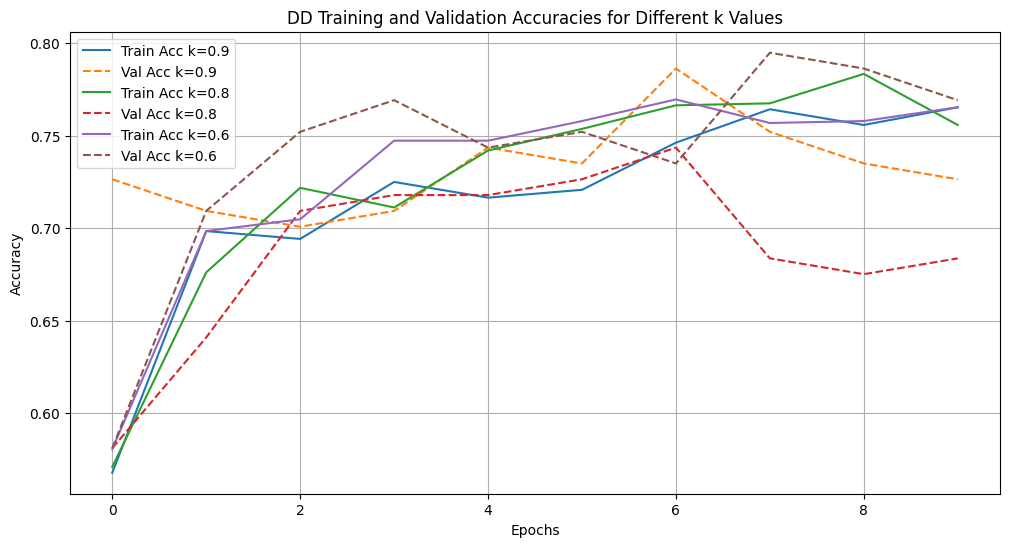

Traing on 10 epochs with k value 0.6::   0%|          | 0/10 [00:00<?, ?epoch/s]

Test Accuracy with best k (0.6): 0.77


In [ ]:
#call main for Enzyme dataset
import matplotlib.pyplot as plt
main('DD',50)

Downsmapling with k = 0.9, 0.8, 0.6:   0%|          | 0/3 [00:00<?, ?k_value/s]

Traing Epoch::   0%|          | 0/100 [00:00<?, ?epoch/s]

For k = 0.9, Best Validation Accuracy: 0.48


Traing Epoch::   0%|          | 0/100 [00:00<?, ?epoch/s]

For k = 0.8, Best Validation Accuracy: 0.48


Traing Epoch::   0%|          | 0/100 [00:00<?, ?epoch/s]

For k = 0.6, Best Validation Accuracy: 0.48
Best k value: 0.9


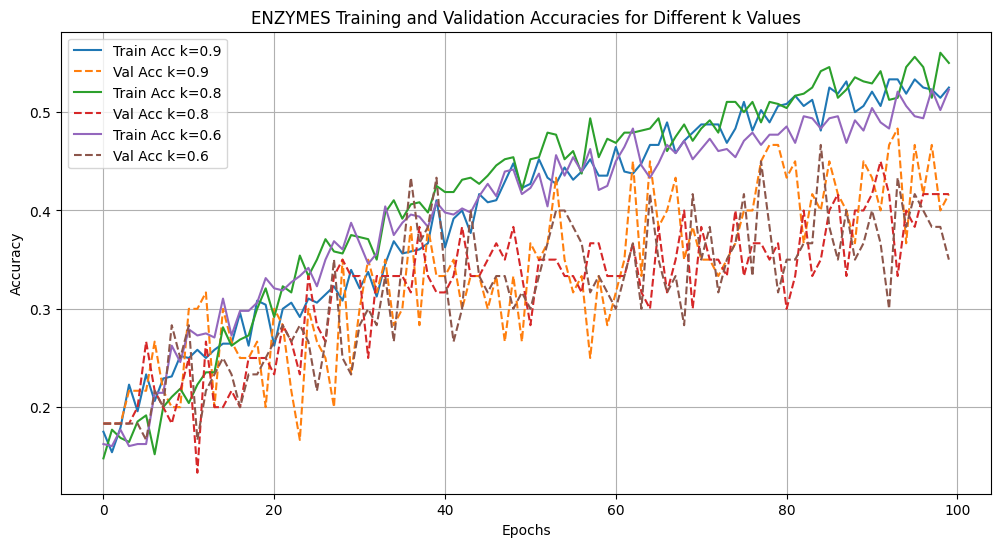

Traing on 100 epochs with k value 0.9::   0%|          | 0/100 [00:00<?, ?epoch/s]

Test Accuracy with best k (0.9): 0.33


In [ ]:
main('ENZYMES',1000)